## Creating Structured Data

In [17]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import numpy as np

In [18]:
RESULTS_DIR = 'runs/no_semstr_results_24_6_18_max_tokens_1024'
JAC_RESULTS_DIR = 'runs/results_24_6_18'
DSPY_RESULTS_DIR = 'runs/no_semstr_results_24_6_18_max_tokens_1024'
EVAL_CONFIG = 'eval.config.nosemstr.json'

In [19]:
import json

with open(EVAL_CONFIG) as f:
    eval_config = json.load(f)

problem_set = {}
for difficulty in eval_config.keys():
    if difficulty not in problem_set:
        problem_set[difficulty] = []
    for problem in eval_config[difficulty].keys():
        problem_set[difficulty].append(problem)

In [20]:
problem_set

{'EASY': ['translation',
  'essay_reviewer',
  'joke_gen',
  'expert_answer',
  'odd_word_out'],
 'MEDIUM': ['mcq_reason',
  'personality_finder',
  'template',
  'text_to_type',
  'taskman'],
 'HARD': ['rpg_level_gen', 'wikipedia']}

In [21]:
ANALYSIS_DIFFICULTY = 'EASY' # 'EASY', 'MEDIUM', 'HARD'

def get_results(difficulty):
    results = {}
    for problem in problem_set[difficulty]:
        results[problem] = get_problem_results(problem)
    return results

def get_problem_results(problem):
    '''Input prompt, Output prompt, Token Usage, Output'''
    return {
        "jac": get_problem_result(problem, "jac"),
        "dspy": get_problem_result(problem, "dspy"),
    }

def get_problem_result(problem, impl="jac"):
    _output = {
        "llm_requests": [],
        "output": ""
    }
    
    file = f"{JAC_RESULTS_DIR if impl=="jac" else DSPY_RESULTS_DIR}/{problem}/{impl}/results.txt"
    with open(file) as f:
        file_contents = f.read()
    
    while True:
        input_prompt_pattern = r'Input Prompt:\n(.*?)\nOutput:'
        input_prompt_match = re.search(input_prompt_pattern, file_contents, re.DOTALL)
        if input_prompt_match:
            input_prompt = input_prompt_match.group(1).strip()
        else:
            break

        output_pattern = r'Output:\n(.*?)\n\{' if impl == "dspy" else r'Output:\n(.*?)\nCompletionUsage'
        output_match = re.search(output_pattern, file_contents, re.DOTALL)
        if output_match:
            output = output_match.group(1).strip()

        file_contents = file_contents[output_match.end():]
        if impl == "dspy":
            slide = 0
            token_pattern = r"'completion_tokens': (\d+), 'prompt_tokens': (\d+), 'total_tokens': (\d+)}\n"
        else:
            slide = 1
            token_pattern = r"(completion_tokens=(\d+), prompt_tokens=(\d+), total_tokens=(\d+))"
        token_match = re.search(token_pattern, file_contents)
        if token_match:
            completion_tokens = int(token_match.group(1+slide))
            prompt_tokens = int(token_match.group(2+slide))
            total_tokens = int(token_match.group(3+slide))

        file_contents = file_contents[token_match.end():]

        _output["llm_requests"].append({
            "prompt": input_prompt,
            "output": output,
            "token_usage": {
                "completion_tokens": completion_tokens,
                "prompt_tokens": prompt_tokens,
                "total_tokens": total_tokens,
            }
        })

    _output["output"] = file_contents.strip()
    return _output

In [22]:
for difficulty in problem_set.keys():
    _results = get_results(difficulty)
    with open(f"{RESULTS_DIR}/{difficulty}.json", "w") as f:
        json.dump(_results, f, indent=4)

## Visualize Token Usage and Cost

In [23]:
def load_results(difficulty):
    with open(f"{RESULTS_DIR}/{difficulty}.json") as f:
        return json.load(f)

In [24]:
ANALYSIS_DIFFICULTY = 'EASY' 
_results = load_results(ANALYSIS_DIFFICULTY)

In [25]:
llm_costs = {
    "completion_tokens": 15/1e6,
    "prompt_tokens":5/1e6,
}

def get_results_df(results):
    rows = []
    for problem, result in results.items():
        jac = result["jac"]
        dspy = result["dspy"]
        rows.append({
            "problem": problem,
            "jac_completion_tokens": sum([llm["token_usage"]["completion_tokens"] for llm in jac["llm_requests"]]),
            "jac_prompt_tokens": sum([llm["token_usage"]["prompt_tokens"] for llm in jac["llm_requests"]]),
            "jac_total_tokens": sum([llm["token_usage"]["total_tokens"] for llm in jac["llm_requests"]]),
            "dspy_completion_tokens": sum([llm["token_usage"]["completion_tokens"] for llm in dspy["llm_requests"]]),
            "dspy_prompt_tokens": sum([llm["token_usage"]["prompt_tokens"] for llm in dspy["llm_requests"]]),
            "dspy_total_tokens": sum([llm["token_usage"]["total_tokens"] for llm in dspy["llm_requests"]]),
            "jac_cost": sum([llm["token_usage"]["completion_tokens"]*llm_costs["completion_tokens"] + llm["token_usage"]["prompt_tokens"]*llm_costs["prompt_tokens"] for llm in jac["llm_requests"]]),
            "dspy_cost": sum([llm["token_usage"]["completion_tokens"]*llm_costs["completion_tokens"] + llm["token_usage"]["prompt_tokens"]*llm_costs["prompt_tokens"] for llm in dspy["llm_requests"]]),
        })
    return pd.DataFrame(rows)

In [26]:
results_df = get_results_df(_results)

In [27]:
results_df

,problem,jac_completion_tokens,jac_prompt_tokens,jac_total_tokens,dspy_completion_tokens,dspy_prompt_tokens,dspy_total_tokens,jac_cost,dspy_cost
0,translation,4,177,181,54,320,374,0.000945,0.002410
1,essay_reviewer,345,1581,1926,2070,2786,4856,0.013080,0.044980
2,joke_gen,19,175,194,59,191,250,0.001160,0.001840
3,expert_answer,112,294,406,170,111,281,0.003150,0.003105
4,odd_word_out,27,256,283,252,529,781,0.001685,0.006425


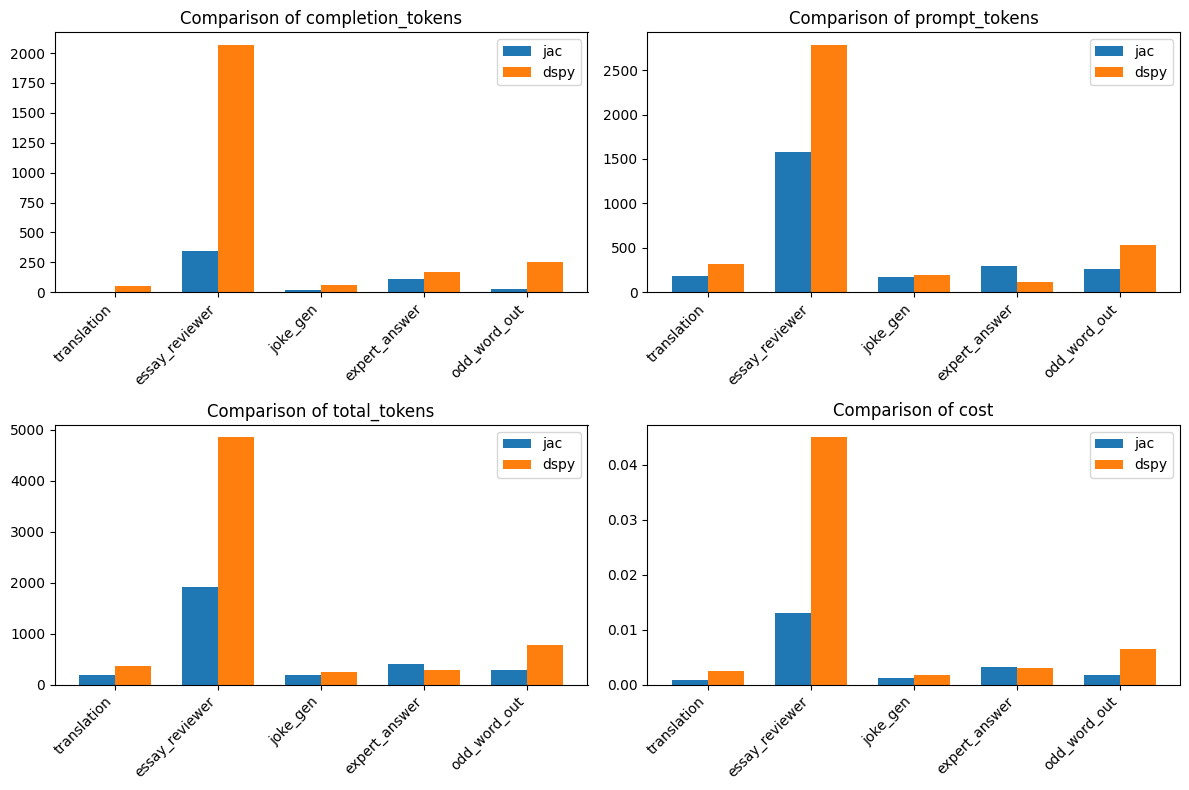

<Figure size 640x480 with 0 Axes>

In [28]:
problems = results_df['problem'].unique()
criteria = ['completion_tokens', 'prompt_tokens', 'total_tokens', 'cost']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

for i, criterion in enumerate(criteria):
    jac_data = results_df[f'jac_{criterion}']
    dspy_data = results_df[f'dspy_{criterion}']

    x = np.arange(len(problems))
    width = 0.35
    axs[i].bar(x - width/2, jac_data, width, label='jac')
    axs[i].bar(x + width/2, dspy_data, width, label='dspy')

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(problems, rotation=45, ha='right')
    axs[i].set_title(f'Comparison of {criterion}')
    axs[i].legend()

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(RESULTS_DIR, f'{ANALYSIS_DIFFICULTY}_token_usage.png'))
results_df.to_csv(os.path.join(RESULTS_DIR, f'{ANALYSIS_DIFFICULTY}_token_usage.csv'), index=False)

## Time Taken Analysis

In [29]:
import pstats

def get_time(problem, impl):
    try:
        p_dspy = pstats.Stats(f'{JAC_RESULTS_DIR if impl=="jac" else DSPY_RESULTS_DIR}/{problem}/{impl}/profile.prof')
        total_time = p_dspy.total_tt
        print(problem, impl, total_time)
        llm_time = p_dspy.sort_stats('cumulative').stats[('/opt/conda/envs/jaclang/lib/python3.12/site-packages/openai/_utils/_utils.py', 243, 'wrapper')][3]
        return total_time, llm_time
    except Exception as e:
        print(e)
        return 0, 0

In [30]:
results_df_with_time = results_df.copy()
results_df_with_time['jac_runtime'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'jac')[0])
results_df_with_time['jac_llm_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'jac')[1])
results_df_with_time['dspy_runtime'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'dspy')[0])
results_df_with_time['dspy_llm_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'dspy')[1])
results_df_with_time["jac_non_llm_time"] = results_df_with_time["jac_runtime"] - results_df_with_time["jac_llm_time"]
results_df_with_time["dspy_non_llm_time"] = results_df_with_time["dspy_runtime"] - results_df_with_time["dspy_llm_time"]
results_df_with_time["jac_non_llm_time_percent"] = results_df_with_time["jac_non_llm_time"] / results_df_with_time["jac_runtime"]
results_df_with_time["dspy_non_llm_time_percent"] = results_df_with_time["dspy_non_llm_time"] / results_df_with_time["dspy_runtime"]

translation jac 1.6837982979999937
essay_reviewer jac 10.839655098999993
joke_gen jac 1.2297007049999993
expert_answer jac 4.971432926999999
odd_word_out jac 1.336259648000001
translation jac 1.6837982979999937
essay_reviewer jac 10.839655098999993
joke_gen jac 1.2297007049999993
expert_answer jac 4.971432926999999


odd_word_out jac 1.336259648000001
translation dspy 5.183028075000005
essay_reviewer dspy 47.45162161100001
joke_gen dspy 2.803268197000002
expert_answer dspy 4.706252256000001
odd_word_out dspy 6.738286887000001
translation dspy 5.183028075000005
essay_reviewer dspy 47.45162161100001
joke_gen dspy 2.803268197000002
expert_answer dspy 4.706252256000001
odd_word_out dspy 6.738286887000001


In [31]:
results_df_with_time

,problem,jac_completion_tokens,jac_prompt_tokens,jac_total_tokens,dspy_completion_tokens,dspy_prompt_tokens,dspy_total_tokens,jac_cost,dspy_cost,jac_runtime,jac_llm_time,dspy_runtime,dspy_llm_time,jac_non_llm_time,dspy_non_llm_time,jac_non_llm_time_percent,dspy_non_llm_time_percent
0,translation,4,177,181,54,320,374,0.000945,0.002410,1.683798,0.974818,5.183028,3.509077,0.708980,1.673951,0.421060,0.322968
1,essay_reviewer,345,1581,1926,2070,2786,4856,0.013080,0.044980,10.839655,10.742305,47.451622,47.427799,0.097350,0.023822,0.008981,0.000502
2,joke_gen,19,175,194,59,191,250,0.001160,0.001840,1.229701,1.184845,2.803268,2.790993,0.044856,0.012275,0.036477,0.004379
3,expert_answer,112,294,406,170,111,281,0.003150,0.003105,4.971433,4.930005,4.706252,4.694704,0.041428,0.011549,0.008333,0.002454
4,odd_word_out,27,256,283,252,529,781,0.001685,0.006425,1.336260,1.280197,6.738287,6.724382,0.056063,0.013905,0.041955,0.002064


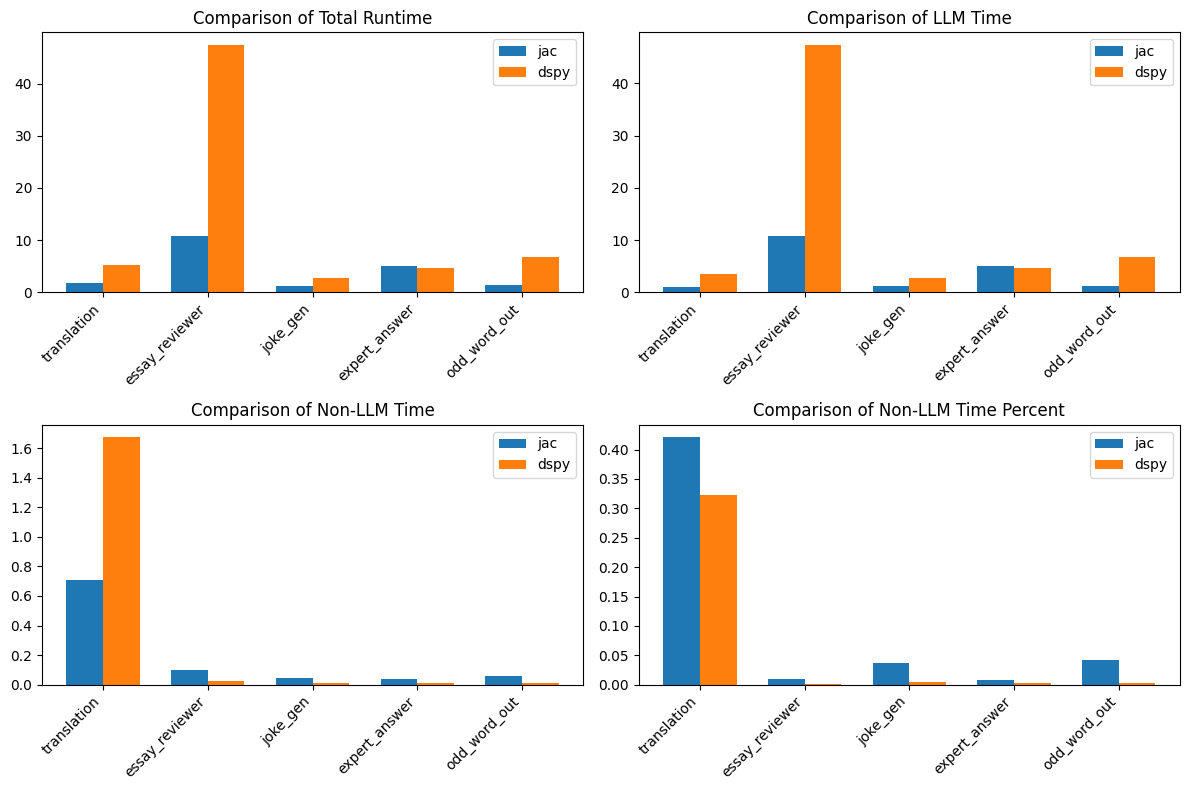

<Figure size 640x480 with 0 Axes>

In [32]:
problems = results_df_with_time['problem'].unique()
criteria = ['runtime','llm_time','non_llm_time','non_llm_time_percent']
titles = ['Total Runtime', 'LLM Time', 'Non-LLM Time', 'Non-LLM Time Percent']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

for i, criterion in enumerate(criteria):  # Truncate the criteria list
    jac_data = results_df_with_time[f'jac_{criterion}']
    dspy_data = results_df_with_time[f'dspy_{criterion}']

    x = np.arange(len(problems))
    width = 0.35
    axs[i].bar(x - width/2, jac_data, width, label='jac')
    axs[i].bar(x + width/2, dspy_data, width, label='dspy')

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(problems, rotation=45, ha='right')
    axs[i].set_title(f'Comparison of {titles[i]}')
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(RESULTS_DIR, f'{ANALYSIS_DIFFICULTY}_runtime.png'))
results_df_with_time.to_csv(os.path.join(RESULTS_DIR, f'{ANALYSIS_DIFFICULTY}_runtime.csv'), index=False)
